In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from tensorflow.keras.callbacks import EarlyStopping
from lightgbm import LGBMRegressor
import tensorflow_probability as tfp
import tensorflow as tf

In [2]:
path = "/kaggle/input/playground-series-s3e25/"
df = pd.read_csv(path + "train.csv")
df_test = pd.read_csv(path + "test.csv")
df.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [74]:
y = df["Hardness"]
X = df.drop(["Hardness","id"],axis=1)
columns = X.columns
X_train,X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=42)

Let's analyse the relation between the features and hardness.

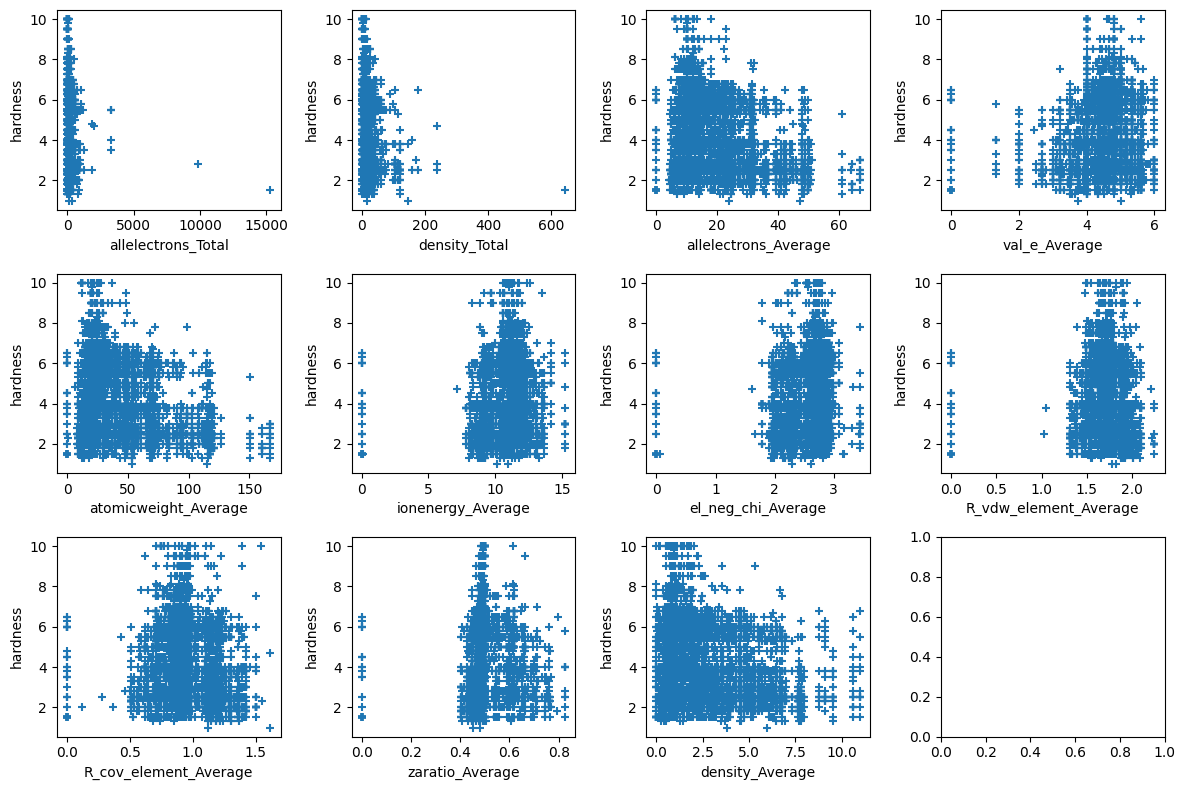

In [5]:
fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(12,8))
axes = axes.flatten()
for i in range(len(columns)):
    axes[i].scatter(X[columns[i]],y,marker="+")
    axes[i].set_xlabel(columns[i])
    axes[i].set_ylabel("hardness")

plt.tight_layout()
plt.show()

Let's remove values that are too different from the mass

In [75]:
to_remove = np.where(X_train["allelectrons_Total"]>1500)[0]
X_train, y_train = X_train.drop(X_train.index[to_remove],axis=0), y_train.drop(y_train.index[to_remove],axis=0)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

to_remove = np.where(X_train["density_Total"]>300)[0]
X_train, y_train = X_train.drop(X_train.index[to_remove],axis=0), y_train.drop(y_train.index[to_remove],axis=0)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

Let's define the median absolute error

In [7]:
def med_abs_err(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=50)

Let's do predictions with an LGBM model, and add the predictions as a column of the training and validation sets.

In [76]:
model_lgbm = LGBMRegressor()
model_lgbm.fit(X,y)
X_train["lgbm"] = model_lgbm.predict(X_train)
X_val["lgbm"] = model_lgbm.predict(X_val)

Let's do a randomised search for the best parameters of an xgboost model

In [ ]:
xgb_model = XGBRegressor()
params = {
     "colsample_bytree": uniform(0.7, 0.3),
     "gamma": uniform(0, 3),
     "learning_rate": uniform(0.001, 0.1),
     "max_depth": randint(3, 15),
     "n_estimators": randint(10, 1000),
     "subsample": uniform(0.7, 0.3)
 }

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=10, n_iter=200, cv=4, verbose=1, n_jobs=1,
                            scoring = "neg_mean_absolute_error",
                            return_train_score=True)

search.fit(X_train, y_train)

best_params = search.best_params_
best_score = search.best_score_

print("Best parameters:",best_params)
print("Best score:",best_score)

In [77]:
model_xgb = XGBRegressor(objective="reg:squarederror",
                           eval_metric=med_abs_err,
                           colsample_bytree=0.865,
                           gamma = 0.867,
                           learning_rate = 0.0155,
                           max_depth = 3,
                           n_estimators = 800,
                           subsample = 0.772)

model_xgb.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val,y_val)], verbose = 200)

[0]	validation_0-rmse:1.67390	validation_0-med_abs_err:1.34264	validation_1-rmse:1.65723	validation_1-med_abs_err:1.34264
[200]	validation_0-rmse:1.01492	validation_0-med_abs_err:0.55634	validation_1-rmse:0.95424	validation_1-med_abs_err:0.54369
[400]	validation_0-rmse:0.97041	validation_0-med_abs_err:0.49765	validation_1-rmse:0.91899	validation_1-med_abs_err:0.50039
[600]	validation_0-rmse:0.94817	validation_0-med_abs_err:0.48176	validation_1-rmse:0.90883	validation_1-med_abs_err:0.49720
[799]	validation_0-rmse:0.93186	validation_0-med_abs_err:0.47117	validation_1-rmse:0.90357	validation_1-med_abs_err:0.48910


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.865, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function med_abs_err at 0x79a9b2ee8a60>,
             feature_types=None, gamma=0.867, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0155, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Let's add the predictions as a column of the training and validation sets.

In [78]:
X_train["xgb"]=model_xgb.predict(X_train)
X_val["xgb"]=model_xgb.predict(X_val)
X_train.drop(["lgbm"],axis=1,inplace=True)
X_val.drop(["lgbm"],axis=1,inplace=True)
columns = X_train.columns
X_train = np.array(X_train.astype("float32"))
y_train = np.array(y_train.astype("float32"))

Let's define a neural network model

In [79]:
model = Sequential([
    layers.InputLayer(input_shape=(len(columns),)),
    
    layers.BatchNormalization(),
    
    layers.Dense(64,activation="relu",kernel_regularizer=regularizers.l1(0.01)),
    
    layers.Dense(128,activation="relu",kernel_regularizer=regularizers.l2(0.01)),

    
    layers.Dense(1,activation="linear")
])

model.compile( optimizer = "Adam",
              loss = med_abs_err,
              metrics = "mae"
)


early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=50,           
    restore_best_weights=True  
)

In [71]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Bat  (None, 13)                52        
 chNormalization)                                                
                                                                 
 dense_23 (Dense)            (None, 64)                896       
                                                                 
 dense_24 (Dense)            (None, 128)               8320      
                                                                 
 dense_25 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9397 (36.71 KB)
Trainable params: 9371 (36.61 KB)
Non-trainable params: 26 (104.00 Byte)
_________________________________________________________________


In [80]:
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=500, batch_size=64, callbacks=[early_stopping])

Epoch 1/500
147/147 [==============================] - 2s 4ms/step - loss: 3.7894 - mae: 2.1110 - val_loss: 3.4537 - val_mae: 2.0789
Epoch 2/500
147/147 [==============================] - 0s 3ms/step - loss: 2.3073 - mae: 1.1267 - val_loss: 2.6466 - val_mae: 1.5065
Epoch 3/500
147/147 [==============================] - 0s 3ms/step - loss: 2.0779 - mae: 1.0872 - val_loss: 1.8272 - val_mae: 0.9773
Epoch 4/500
147/147 [==============================] - 0s 3ms/step - loss: 1.8399 - mae: 1.0032 - val_loss: 1.7613 - val_mae: 0.9862
Epoch 5/500
147/147 [==============================] - 0s 3ms/step - loss: 1.6682 - mae: 0.9442 - val_loss: 1.6585 - val_mae: 1.0128
Epoch 6/500
147/147 [==============================] - 0s 3ms/step - loss: 1.5611 - mae: 0.9475 - val_loss: 1.4562 - val_mae: 0.9462
Epoch 7/500
147/147 [==============================] - 0s 3ms/step - loss: 1.4357 - mae: 0.9156 - val_loss: 1.4499 - val_mae: 1.0178
Epoch 8/500
147/147 [==============================] - 0s 3ms/step - 

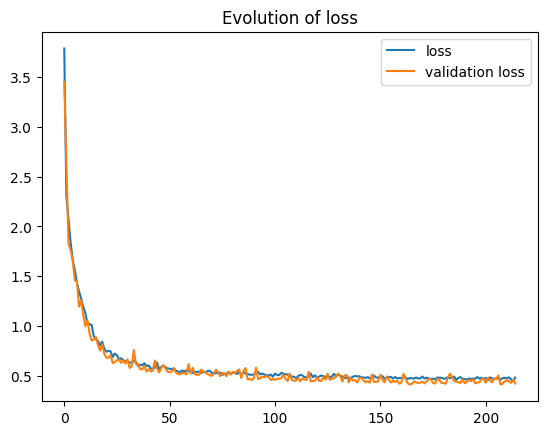

In [81]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
x = np.arange(len(loss))

plt.plot(x,loss,label="loss")
plt.plot(x,val_loss, label="validation loss")
plt.title("Evolution of loss")
plt.legend()
plt.show()

In [66]:
X_test = df_test.drop("id",axis=1)
Id = df_test["id"]
X_test["lgbm"] = model_lgbm.predict(X_test)
X_test["xgb"] = model_xgb.predict(X_test)
X_test = np.array(X_test).astype("float32")
y_pred = model.predict(X_test)
y_pred = np.reshape(y_pred,(len(y_pred),))
output= pd.DataFrame({'id':Id,'Hardness':y_pred})
output.to_csv("submission.csv",index=False)

217/217 [==============================] - 0s 2ms/step
